# I will get this model to work today.
today.

In [77]:
import math
from itertools import product
from typing import List
import random
import pandas as pd
import torch
from torch import Tensor, LongTensor
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric
from torch_geometric.data import Data
from torch_geometric.data import Dataset
import matplotlib.pyplot as plt

In [185]:
class EVGNN(nn.Module):
    def __init__(self) -> None:
        super(EVGNN, self).__init__()
        # size of the embedding space
        self.embed_dim = 4
        
        self.embedding = nn.Embedding(118, self.embed_dim)
        self.mp1 = EVMPLayer(self.embed_dim)
        self.prediction1 = RowWiseFCL(self.embed_dim, 1) 

    def forward(self, data = Data) -> float:
        print('IN MODEL\n', data)
        x = self.embedding(data['x'])
        print('EMBEDDING\n', x)
        x = self.mp1(x, data.edge_distances)
        x = F.normalize(x, p=1, dim=0)
        print('MESSAGE PASSING 1\n', x)
        x = self.prediction1(x)
        print('PREDICTION 1\n', x)
        U_hat = torch.sum(x)
        print('FINAL PREDICTION\n', U_hat)

        return U_hat

In [186]:
class EVMPLayer(nn.Module):
    def __init__(self, embed_dim: int) -> None:
        super(EVMPLayer, self).__init__()
        self.embed_dim = embed_dim
        self.act = nn.Tanh()
        message_input_size = 2 * embed_dim + 1
        
        # take in a message tensor of size 2 * embed_dim + 1 and get out a new h_i of size embed_dim
        self.message_mlp = nn.Sequential(nn.Linear(message_input_size, embed_dim), self.act)
        
        # take in a message tensor of size embed_dim and an original h_i of size embed_dim and get out a new h_i of size embed_dim
        self.update_node_mlp = nn.Sequential(nn.Linear(2 * embed_dim, embed_dim), self.act)
                
    def make_message(self, source_tensor: int, target_tensor: int, distance: float) -> Tensor:
        combined_tensor = torch.cat((source_tensor.view(-1), target_tensor.view(-1), torch.Tensor([distance])))
        return self.message_mlp(combined_tensor)
    
    def update_node(self, node_tensor: Tensor, message_tensor: Tensor) -> Tensor:
        combined_tensor = torch.cat((node_tensor, message_tensor)).view(1,-1)
        return self.update_node_mlp(combined_tensor)
    
    def forward(self, embed_tensor: Tensor, edge_distances: Tensor) -> Tensor:
        new_embed_tensor = torch.zeros_like(embed_tensor)
        # for each molecule in the dataset
        for ix, source in enumerate(embed_tensor):
            # create a tensor that tracks the sum of the messages
            message_sum = torch.zeros_like(source)
            # for each other molecule in the dataset
            for jx, target in enumerate(embed_tensor):
                if ix != jx:
                    # add the message tensor between them to the sum tensor
                    message_sum += self.make_message(source, target, edge_distances[ix,jx].item())
            # update the tensor that keeps track of all molecule embeddings by making its row ix the new embedding of the molecule
            new_embed_tensor[ix] = self.update_node(source, message_sum)
        
        return new_embed_tensor
            

In [187]:
class RowWiseFCL(nn.Module): 
    def __init__(self, in_dim: int, out_dim: int) -> None: 
        super(RowWiseFCL, self).__init__() 
        self.out_dim = out_dim
        self.row_layer = nn.Sequential(nn.Linear(in_dim, out_dim), nn.Tanh())
      
    def forward(self, embed_tensor: Tensor) -> Tensor:
        new_embed_tensor = torch.zeros(embed_tensor.size(0), self.out_dim)
        for ix, row in enumerate(embed_tensor):
            new_embed_tensor[ix] = self.row_layer(row)
        return new_embed_tensor

In [188]:
class MoleculesDataset(Dataset):
    def __init__(self, data: List[Data]) -> None:
        super().__init__()
        self.data = data
        
    def len(self) -> int:
        return len(self.data)
    
    def get(self, idx: int) -> Data:
        return self.data[idx]

In [189]:
def compute_distance(pos1: Tensor, pos2: Tensor) -> float:
    return torch.sum(torch.pow(torch.sub(pos1, pos2), 2)).item()

In [190]:
def make_complete_edge_indices(n: int) -> LongTensor:
    edges = list(filter(lambda e: e[0] != e[1], product(range(n), range(n))))
    return torch.tensor(edges, dtype=torch.long).T

In [191]:
def make_edge_distances(positions: Tensor) -> Tensor:
    edge_distances = torch.zeros(positions.size(0), positions.size(0))
    for ix, source_position in enumerate(positions):
        for jx, target_position in enumerate(positions):
            edge_distances[ix][jx] = compute_distance(source_position, target_position)
    return edge_distances

In [192]:
def criterion(pred: float, target: float) -> float:
    return (pred - target) ** 2

In [193]:
path_head = 'baby_QM9/raw/'

node_features_df = pd.read_csv(path_head + 'node_attributes.txt', header=None)
node_features = torch.tensor(node_features_df.values)

graph_features_df = pd.read_csv(path_head + 'Y.txt', header=None)
graph_features = torch.tensor(graph_features_df.values)

atomic_numbers = node_features[:,5].long()

positions = node_features[:,-3:]

atomization_energies = graph_features[:,13]
atomization_energies_list = atomization_energies.tolist()

new_graph_node_indices = [0]
node_indicators_df = pd.read_csv(path_head + 'graph_indicator.txt', header=None)
node_indicators = node_indicators_df.values.tolist()
for ix in range(len((node_indicators)))[1:]:
    if node_indicators[ix] != node_indicators[ix-1]:
        new_graph_node_indices.append(ix)
new_graph_node_indices.append(len(node_indicators))

molecules_list = []
for start, end in zip(new_graph_node_indices, new_graph_node_indices[1:]):
    x = atomic_numbers.clone()[start:end].view(-1, 1)
    edge_index = make_complete_edge_indices(end-start)
    y = torch.Tensor([atomization_energies_list.pop(0)])
    pos = positions.clone()[start:end]
    edge_distances = make_edge_distances(pos)
    molecule = Data(x = x, edge_index = edge_index, y = y, pos = pos, edge_distances = edge_distances)
    molecules_list.append(molecule)
    
molecules_dataset = MoleculesDataset(molecules_list)

In [194]:
model = EVGNN()
optim = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn = nn.MSELoss()
losses = []
predictions = []
targets = []
epochs = range(1000)

# training loop
model.train()
data = molecules_dataset[1]
for epoch in epochs:
    # for data in molecules_dataset[:1]:
    U_hat = model(data)
    predictions.append(U_hat.item())
    U = data['y']
    targets.append(U.item())
    loss = loss_fn(U_hat, U)
    losses.append(loss.item())
    optim.zero_grad()
    loss.backward()
    optim.step()

IN MODEL
 Data(x=[4, 1], edge_index=[2, 12], y=[1], pos=[4, 3], edge_distances=[4, 4])
EMBEDDING
 tensor([[[-0.0972, -2.4576, -1.4099, -0.3600]],

        [[-0.1692, -0.5856,  0.3046, -1.5461]],

        [[-0.1692, -0.5856,  0.3046, -1.5461]],

        [[-0.1692, -0.5856,  0.3046, -1.5461]]], grad_fn=<EmbeddingBackward0>)
MESSAGE PASSING 1
 tensor([[[-0.5316, -0.4076,  0.0691,  0.0517]],

        [[-0.1561, -0.1975, -0.3103,  0.3161]],

        [[-0.1561, -0.1975, -0.3103,  0.3161]],

        [[-0.1561, -0.1975, -0.3103,  0.3161]]], grad_fn=<DivBackward0>)
PREDICTION 1
 tensor([[0.3485],
        [0.3894],
        [0.3894],
        [0.3895]], grad_fn=<CopySlices>)
FINAL PREDICTION
 tensor(1.5168, grad_fn=<SumBackward0>)
IN MODEL
 Data(x=[4, 1], edge_index=[2, 12], y=[1], pos=[4, 3], edge_distances=[4, 4])
EMBEDDING
 tensor([[[-0.1072, -2.4476, -1.4199, -0.3500]],

        [[-0.1792, -0.5756,  0.2946, -1.5561]],

        [[-0.1792, -0.5756,  0.2946, -1.5561]],

        [[-0.1792, -0.5756

/usr/local/Caskroom/miniconda/base/envs/GeometricDL/lib/python3.12/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor([[[-0.1729, -2.3939, -1.4924, -0.3312]],

        [[-0.2314, -0.5233,  0.2141, -1.6026]],

        [[-0.2314, -0.5233,  0.2141, -1.6026]],

        [[-0.2314, -0.5233,  0.2141, -1.6026]]], grad_fn=<EmbeddingBackward0>)
MESSAGE PASSING 1
 tensor([[[-0.3123, -0.2283,  0.2656,  0.2396]],

        [[-0.2292, -0.2572,  0.2448,  0.2535]],

        [[-0.2292, -0.2572,  0.2448,  0.2535]],

        [[-0.2292, -0.2572,  0.2448,  0.2535]]], grad_fn=<DivBackward0>)
PREDICTION 1
 tensor([[-0.3428],
        [-0.3089],
        [-0.3089],
        [-0.3089]], grad_fn=<CopySlices>)
FINAL PREDICTION
 tensor(-1.2696, grad_fn=<SumBackward0>)
IN MODEL
 Data(x=[4, 1], edge_index=[2, 12], y=[1], pos=[4, 3], edge_distances=[4, 4])
EMBEDDING
 tensor([[[-0.1734, -2.3936, -1.4929, -0.3312]],

        [[-0.2317, -0.5231,  0.2135, -1.6028]],

        [[-0.2317, -0.5231,  0.2135, -1.6028]],

        [[-0.2317, -0.5231,  0.2135, -1.6028]]], grad_fn=<EmbeddingBackward0>)
MESSAGE PASSING 1
 tensor([[[-0.3107, -0

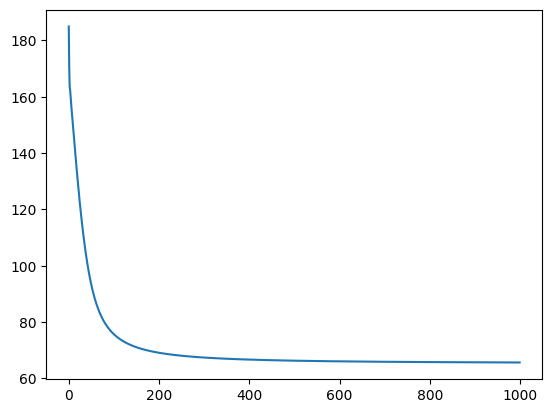

In [195]:
import matplotlib.pyplot as plt

xs = [x for x in range(len(losses))]

# plt.plot(xs, losses)
plt.plot(xs, losses)
plt.show()
plt.close()

In [173]:
for prediction in predictions:
    print(prediction)

-0.15403282642364502
-0.6100214719772339
-0.8519117832183838
-0.8060312271118164
-1.1291916370391846
-1.2378299236297607
-1.3400212526321411
-1.4410024881362915
-1.540095329284668
-1.6368720531463623
-1.7312376499176025
-1.8230140209197998
-1.9120405912399292
-1.9981846809387207
-2.0813467502593994
-2.1614623069763184
-2.2384982109069824
-2.3124470710754395
-2.3833210468292236
-2.45114803314209
-2.5159687995910645
-2.577836275100708
-2.6368119716644287
-2.6929702758789062
-2.746396064758301
-2.797184705734253
-2.84543776512146
-2.891256093978882
-2.934739112854004
-2.975985050201416
-3.015094757080078
-3.0521719455718994
-3.0873191356658936
-3.1206371784210205
-3.152221918106079
-3.1821646690368652
-3.21055269241333
-3.237471580505371
-3.2630040645599365
-3.2872297763824463
-3.310225486755371
-3.332062244415283
-3.3528056144714355
-3.37251877784729
-3.3912622928619385
-3.4090933799743652
-3.4260663986206055
-3.442232370376587
-3.4576382637023926
-3.472327947616577
-3.486342668533325
-3

In [158]:
losses

[146.60740661621094,
 104.26905059814453,
 87.10122680664062,
 79.22330474853516,
 74.7957992553711,
 72.05146789550781,
 70.25875854492188,
 69.05228424072266,
 68.22300720214844,
 67.64523315429688,
 67.2374496459961,
 66.94356536865234,
 66.7255630493164,
 66.55862426757812,
 66.42697143554688,
 66.3204345703125,
 66.23239135742188,
 66.15838623046875,
 66.09529113769531,
 66.04085540771484,
 65.99345397949219,
 65.9518051147461,
 65.91499328613281,
 65.8822021484375,
 65.8528823852539,
 65.82650756835938,
 65.80268096923828,
 65.78108215332031,
 65.76142120361328,
 65.74346160888672,
 65.72701263427734,
 65.7118911743164,
 65.69795989990234,
 65.6850814819336,
 65.67314910888672,
 65.66204833984375,
 65.65172576904297,
 65.64209747314453,
 65.63308715820312,
 65.62464141845703,
 65.61671447753906,
 65.6092300415039,
 65.60218811035156,
 65.59554290771484,
 65.58924102783203,
 65.58326721191406,
 65.57759857177734,
 65.57218933105469,
 65.56704711914062,
 65.5621337890625,
 65.55745